In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import matplotlib.colors as mcolors
import mcspace.vis_tools as vis

import scipy.cluster.hierarchy as sch

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")

In [4]:
runpath = rootpath / "paper" / "human_runs" / "runs"

In [5]:
treepath = rootpath / "data" / "human_experiments" / "human_otus_tree" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [6]:
outpath = basepath / "figs_human_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model results

In [7]:
respath = get_min_loss_path(runpath, np.arange(10))

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

0
1
2
3
4
5
6
7
8
9
3


In [8]:
model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy_temp = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][1].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

C:\Users\Gary\AppData\Local\Temp\ipykernel_169080\2930395400.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(respath / MODEL_FILE)


In [9]:
print(times)
print(subjects)
print(num_otus)

[1, 2, 3, 4, 5]
['H11']
58


### load final taxonomy

In [10]:
taxfile =  rootpath / "data" / "human_experiments" / "gappa_taxonomy" / "human_taxonomy.csv"
finaltax = pd.read_csv(taxfile, index_col=0)

In [11]:
taxonomy_temp.head()

,Kingdom,Phylum,Class,Order,Family,Genus
Otu,,,,,,
Otu121,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,na
Otu14,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,na
Otu150,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,uncultured
Otu37,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Otu6,Bacteria,Actinobacteriota,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium


In [12]:
finaltax.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu1720,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter valericigenes
Otu3529,Bacteria,Proteobacteria,Gammaproteobacteria,Thiotrichales,Thiotrichaceae,Thiothrix,na
Otu3620,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,na
Otu93,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,na
Otu3524,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans


In [13]:
taxlist = list(taxonomy_temp.index)

In [14]:
taxonomy = finaltax.loc[taxlist,:]

In [15]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na


# Get summary results

In [16]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

## get relative abundance data

In [17]:
def get_bulk_relative_abundances(reads, times, subjects, taxonomy):
    num_otus = taxonomy.shape[0]
    multiind = pd.MultiIndex.from_frame(taxonomy)
    ntime = len(times)
    
    radfs = {}
    for s in subjects:
        ra = np.zeros((ntime, num_otus))
        for i,t in enumerate(times):
            counts = reads[t][s].cpu().detach().clone().numpy()
            rabun = counts/counts.sum(axis=1, keepdims=True)
            bulk_rabun = np.mean(rabun, axis=0)
            ra[i,:] = bulk_rabun
        df = pd.DataFrame(data=ra.T, index=multiind, columns=times)
        radfs[s] = df
    return radfs

In [18]:
reads = data['count_data'] #.cpu().detach().clone().numpy()
bulktemp = get_bulk_relative_abundances(reads, times, subjects, taxonomy.reset_index())

In [19]:
bulk = bulktemp['H11'].reset_index()[['Otu'] + times].set_index('Otu')

In [20]:
bulk.head()

,1,2,3,4,5
Otu,,,,,
Otu121,0.006974,0.007406,0.000576,0.002787,0.001610
Otu14,0.020579,0.078228,0.025125,0.103553,0.044628
Otu150,0.000119,0.028550,0.000008,0.000006,0.000003
Otu37,0.001440,0.003773,0.002748,0.006807,0.004576
Otu6,0.019864,0.006888,0.062092,0.010495,0.004887


# Get figure data

### get most and least variable assemblages and subset of taxa

In [21]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [22]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [23]:
avebeta.head()

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005117,0.039085,0.005723,0.005950,0.006165,0.004470,0.015014,0.012182,0.008761,0.002896,...,0.003873,0.003566,0.021433,0.010261,0.002778,0.024999,0.004944,0.006969,0.010437,0.004217
2,0.004593,0.008105,0.014682,0.023463,0.010870,0.010096,0.008150,0.032711,0.012103,0.011323,...,0.010348,0.011386,0.018813,0.010290,0.006937,0.010800,0.012161,0.013865,0.021480,0.010655
3,0.002221,0.031616,0.013289,0.023487,0.008043,0.011185,0.008503,0.014163,0.006983,0.007509,...,0.028506,0.007943,0.032365,0.015757,0.002844,0.003489,0.007524,0.015901,0.012181,0.012319
4,0.002421,0.008357,0.029459,0.010992,0.017564,0.010880,0.006789,0.065142,0.015938,0.019663,...,0.006704,0.009717,0.011818,0.006048,0.007669,0.000934,0.028143,0.028816,0.032913,0.014560
5,0.000869,0.005554,0.037083,0.006364,0.010231,0.008429,0.010956,0.021562,0.012279,0.019788,...,0.005761,0.011226,0.007015,0.005367,0.009477,0.001245,0.014719,0.030778,0.034695,0.013979


In [24]:
beta = avebeta.T
beta['T-max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance'] = np.log(beta).var(axis=1)
beta = beta.T

In [25]:
beta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005117,0.039085,0.005723,0.005950,0.006165,0.004470,0.015014,0.012182,0.008761,0.002896,...,0.003873,0.003566,0.021433,0.010261,0.002778,0.024999,0.004944,0.006969,0.010437,0.004217
2,0.004593,0.008105,0.014682,0.023463,0.010870,0.010096,0.008150,0.032711,0.012103,0.011323,...,0.010348,0.011386,0.018813,0.010290,0.006937,0.010800,0.012161,0.013865,0.021480,0.010655
3,0.002221,0.031616,0.013289,0.023487,0.008043,0.011185,0.008503,0.014163,0.006983,0.007509,...,0.028506,0.007943,0.032365,0.015757,0.002844,0.003489,0.007524,0.015901,0.012181,0.012319
4,0.002421,0.008357,0.029459,0.010992,0.017564,0.010880,0.006789,0.065142,0.015938,0.019663,...,0.006704,0.009717,0.011818,0.006048,0.007669,0.000934,0.028143,0.028816,0.032913,0.014560
5,0.000869,0.005554,0.037083,0.006364,0.010231,0.008429,0.010956,0.021562,0.012279,0.019788,...,0.005761,0.011226,0.007015,0.005367,0.009477,0.001245,0.014719,0.030778,0.034695,0.013979
T-max,0.005117,0.039085,0.037083,0.023487,0.017564,0.011185,0.015014,0.065142,0.015938,0.019788,...,0.028506,0.011386,0.032365,0.015757,0.009477,0.024999,0.028143,0.030778,0.034695,0.014560
Mean,0.003390,0.021967,0.022886,0.015624,0.011739,0.009374,0.010737,0.035150,0.012000,0.013494,...,0.013950,0.009204,0.020635,0.010580,0.006530,0.011077,0.015939,0.021185,0.024400,0.011715
Variance,0.405863,0.690209,0.458717,0.369849,0.146785,0.106564,0.092470,0.452442,0.090736,0.497698,...,0.604190,0.171503,0.300118,0.176100,0.275729,1.837040,0.412682,0.297909,0.248954,0.191940


#### least changed (singletons and multi-way)

In [26]:
otu_threshold = 0.05

In [27]:
persistent = beta.columns[beta.loc['Variance',:]<0.1]
# print(persistent)

singletons = persistent[((thetadf.loc[:,persistent]>otu_threshold).sum(axis=0) == 1)]
perst = persistent[~((thetadf.loc[:,persistent]>otu_threshold).sum(axis=0) == 1)]
print(singletons)
print(perst)

# also cluster columns...
theta_persistent = np.log10(thetadf.loc[:,perst] + 1e-20).values

data_matrix=theta_persistent.T
row_dist = sch.linkage(data_matrix, method='ward')
persist_row_order = sch.leaves_list(row_dist)

persistent = perst[persist_row_order]
print(persistent)

Index(['A17', 'A4', 'A61'], dtype='object', name='Assemblage')
Index(['A15', 'A22', 'A23', 'A27', 'A56', 'A57'], dtype='object', name='Assemblage')
Index(['A23', 'A56', 'A15', 'A27', 'A22', 'A57'], dtype='object', name='Assemblage')


#### most changed

In [28]:
nx = 3

sigchanged = []
for aidx in beta.columns:
    temp = beta.loc[:,aidx]
    for day in times:
        rest = np.array([j for j in times if j != day])
        maxother = np.amax(temp[rest].values)
        current = temp[day]
        if current >= maxother*nx:
            sigchanged.append(aidx)
        
sigchanged = pd.Index(sigchanged)
print(sigchanged)

# cluster columns...
theta_var = np.log10(thetadf.loc[:,sigchanged] + 1e-20).values

data_matrix=theta_var.T
row_dist = sch.linkage(data_matrix, method='ward')
row_order = sch.leaves_list(row_dist)

sigchanged = sigchanged[row_order]
print(sigchanged)

Index(['A21', 'A38', 'A5', 'A51', 'A54', 'A60'], dtype='object')
Index(['A38', 'A5', 'A51', 'A60', 'A21', 'A54'], dtype='object')


#### get taxa subset

In [29]:
betasub = list(set(singletons).union(set(persistent)).union(set(sigchanged)))
otu_sub = thetadf.index[(thetadf.loc[:,betasub]>otu_threshold).any(axis=1)].get_level_values('Otu')

# Render figure

In [30]:
ncomm_max = 50
notu_max = 50

tree_ratio = 0.1
gap_ratio = 0.15

ntime = len(times)
nsubj = len(subjects)
notus = len(otu_sub)

In [31]:
nsing = len(singletons)
npert = len(persistent)
nvar = len(sigchanged)
ncomm = nsing + npert + nvar

In [32]:
theta_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","green"])
theta_vmin = -2.5
theta_vmax = 0
linewidth = 0.1
linecolor = '#e6e6e6'

original tree size: 3923
pruned tree size: 19


C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


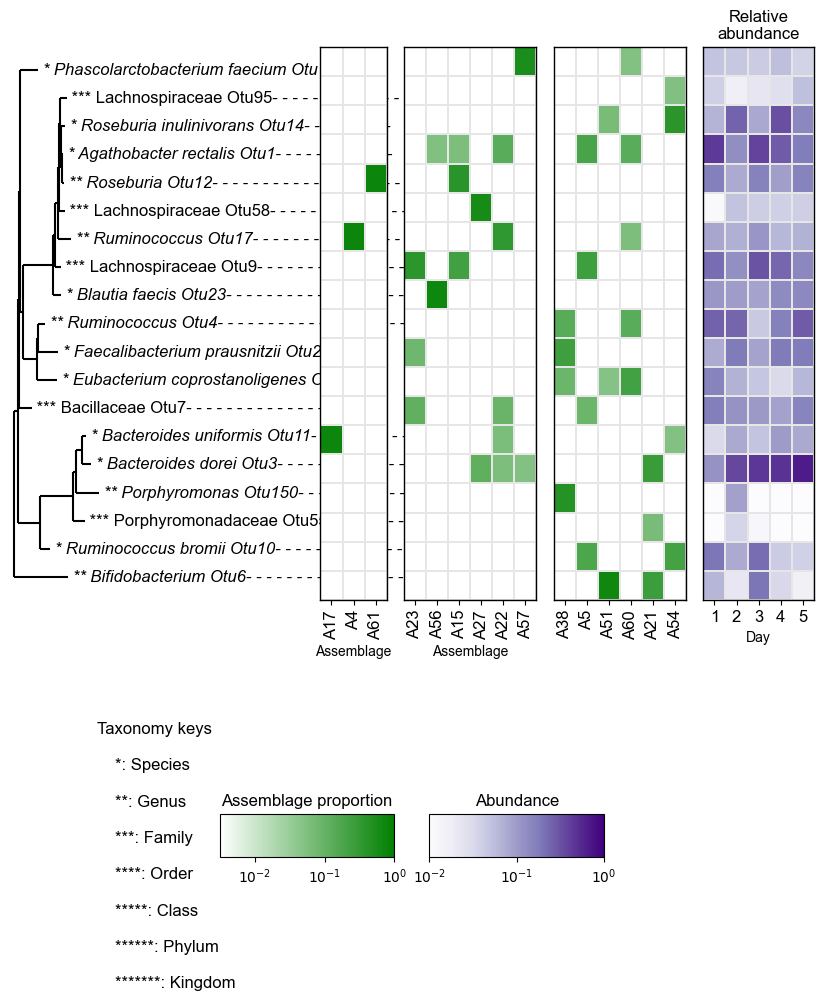

In [33]:
scale=2
tree_fontsize=12

# set aspect ratios
# add buffers so scales always same?
lgd_ratio = 0.1
lgd_gap = 0.1
hratios = [notus/notu_max, lgd_ratio, lgd_gap]
hratios.append(1.0 - (notus/notu_max)) # buffer?

# width ratios
wratios = [tree_ratio, gap_ratio, 
           nsing/ncomm_max, npert/ncomm_max, nvar/ncomm_max, ntime/ncomm_max,
           1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=4,ncols=7,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_tree = fig.add_subplot(gs[0,0])
ax_sing = fig.add_subplot(gs[0,2])
ax_pert = fig.add_subplot(gs[0,3])
ax_var = fig.add_subplot(gs[0,4])
ax_ra = fig.add_subplot(gs[0,5])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_theta_lgd = fig.add_subplot(gs_lgd[1,1])
ax_ra_lgd = fig.add_subplot(gs_lgd[1,2])


# plot tree
taxa = taxonomy.reset_index().copy()
taxa = taxa.set_index("Otu")
taxa_subset = taxa.loc[otu_sub,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize)

# plot assemblages
ax_thetas = [ax_sing, ax_pert, ax_var]
bsub = [singletons, persistent, sigchanged]
for comm_order, ax_theta in zip(bsub, ax_thetas):
    thetadf2 = thetadf.copy()
    thetadf2[thetadf2<otu_threshold] = 0
    theta_plot = np.log10(thetadf2.loc[otu_order,comm_order])
    ax_theta=sns.heatmap(theta_plot, ax=ax_theta, cmap=theta_cmap, square=False, cbar=False, vmin=theta_vmin, vmax=theta_vmax, 
                         linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=False) #True)
    # ax_theta.set_xticklabels([f"A{i+1}" for i in range(len(beta_keep))], rotation=90, fontsize=tree_fontsize)
    ax_theta.set_xticklabels(ax_theta.get_xticklabels(), fontsize=tree_fontsize, rotation=90)
#     ax_theta.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)
    ax_theta.set_ylabel("")
    ax_theta=vis.add_border(ax_theta)
    
# plot relative abundances
ax_ra=sns.heatmap(np.log10(bulk.loc[otu_order,times]), cmap='Purples', vmin=-2.5, vmax=-0.5,ax=ax_ra,
                   linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=False, cbar=False)
ax_ra = vis.add_border(ax_ra)
ax_ra.set_ylabel("")
ax_ra.set_xlabel("Day")
ax_ra.set_xticklabels(ax_ra.get_xticklabels(), rotation=0, fontsize=tree_fontsize)
ax_ra.set_title("Relative\nabundance", fontsize=tree_fontsize)


# plot legend...
# plot legend
norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Assemblage proportion")

norm = mpl.colors.Normalize(vmin=-2, vmax=0)
ax_ra_lgd=mpl.colorbar.ColorbarBase(ax_ra_lgd, cmap="Purples", norm=norm, orientation='horizontal')
ax_ra_lgd.ax.set_xticks([0,-1,-2])
ax_ra_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_ra_lgd.ax.set_title("Abundance")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

### try centering map by 'squishing' heatmap

In [34]:
tree_text_len = 79

In [35]:
ncomm_max = 50
notu_max = 50

tree_ratio = 0.1
gap_ratio = 0.2

In [36]:
theta_vmin=-2
theta_vmax=0
theta_cmap = sns.light_palette("green", reverse=False, as_cmap=True)
theta_cmap.set_under('white')
linewidth = 0.5

original tree size: 3923
pruned tree size: 19


C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


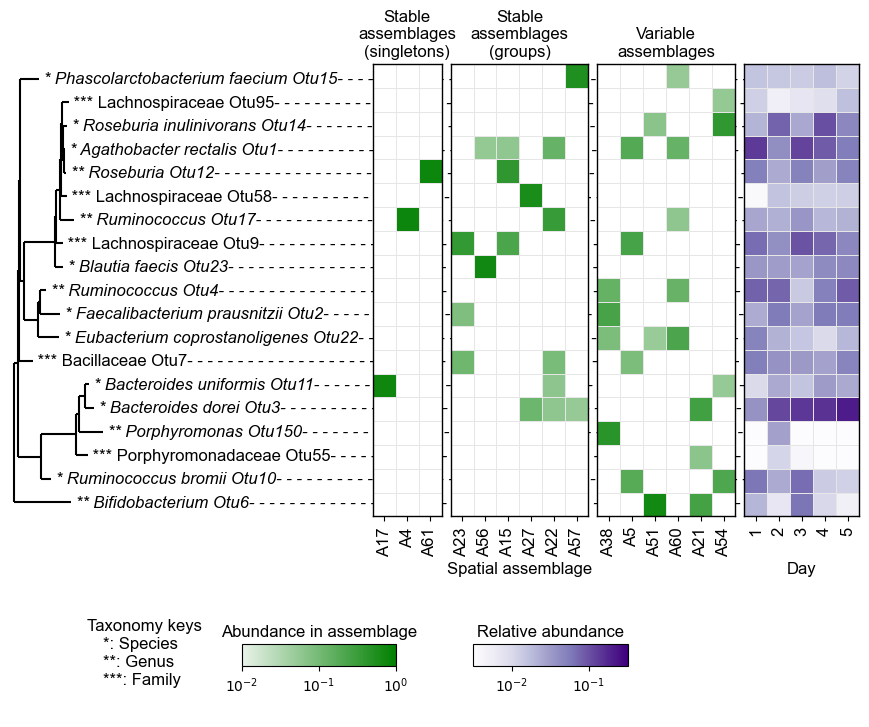

In [40]:
scale=2
tree_fontsize=12

# set aspect ratios
# add buffers so scales always same?
lgd_ratio = 0.09
lgd_gap = 0.06
hratios = [notus/notu_max, lgd_ratio, lgd_gap]
hratios.append(1.0 - (notus/notu_max)) # buffer?

# width ratios
wratios = [tree_ratio, gap_ratio, 
           nsing/ncomm_max, npert/ncomm_max, nvar/ncomm_max, ntime/ncomm_max,
           1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,0.8*11.5*scale))
gs = fig.add_gridspec(nrows=4,ncols=7,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.02)

# create subplots, get axes
ax_tree = fig.add_subplot(gs[0,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.01
squish_hspace = 0

gs_sing = gs[0,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_sing = fig.add_subplot(gs_sing[1,0])
gs_pert = gs[0,3].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_pert = fig.add_subplot(gs_pert[1,0])
gs_var = gs[0,4].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_var = fig.add_subplot(gs_var[1,0])
gs_ra = gs[0,5].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_ra = fig.add_subplot(gs_ra[1,0])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_ra_lgd = fig.add_subplot(gs_lgd[0,2])


# plot tree
taxa = taxonomy.reset_index().copy()
taxa = taxa.set_index("Otu")
taxa_subset = taxa.loc[otu_sub,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize, text_len=tree_text_len)

# plot assemblages
ax_thetas = [ax_sing, ax_pert, ax_var]
bsub = [singletons, persistent, sigchanged]
titles = ['Stable\nassemblages\n(singletons)', 'Stable\nassemblages\n(groups)', 'Variable\nassemblages']
for comm_order, ax_theta, ttl in zip(bsub, ax_thetas, titles):
    thetadf2 = thetadf.copy()
    thetadf2[thetadf2<otu_threshold] = 0
    theta_plot = np.log10(thetadf2.loc[otu_order,comm_order])
    ax_theta=sns.heatmap(theta_plot, ax=ax_theta, cmap=theta_cmap, square=False, cbar=False, vmin=theta_vmin, vmax=theta_vmax, 
                         linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=False) #True)
#     ax_theta.set_yticklabels("")
    # ax_theta.set_xticklabels([f"A{i+1}" for i in range(len(beta_keep))], rotation=90, fontsize=tree_fontsize)
    ax_theta.set_xticklabels(ax_theta.get_xticklabels(), fontsize=tree_fontsize, rotation=90)
#     ax_theta.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)
    ax_theta.set_ylabel("")
    ax_theta.set_xlabel("")
    ax_theta=vis.add_border(ax_theta)
    ax_theta.set_title(ttl, fontsize=tree_fontsize)
ax_pert.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)
    
# plot relative abundances
ax_ra=sns.heatmap(np.log10(bulk.loc[otu_order,times]), cmap='Purples', vmin=-2.5, vmax=-0.5,ax=ax_ra,
                   linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=False, cbar=False)
ax_ra = vis.add_border(ax_ra)
ax_ra.set_ylabel("")
ax_ra.set_xlabel("Day", fontsize=tree_fontsize)
ax_ra.set_xticklabels(ax_ra.get_xticklabels(), rotation=90, fontsize=tree_fontsize)
# ax_ra.set_title("Relative\nabundance", fontsize=tree_fontsize)


# plot legend...
# plot legend
norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")

norm = mpl.colors.Normalize(vmin=-2.5, vmax=-0.5)
ax_ra_lgd=mpl.colorbar.ColorbarBase(ax_ra_lgd, cmap="Purples", norm=norm, orientation='horizontal')
ax_ra_lgd.ax.set_xticks([-1,-2])
ax_ra_lgd.ax.set_xticklabels([r'$10^{-1}$',r'$10^{-2}$'])
ax_ra_lgd.ax.set_title("Relative abundance")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family'] #, 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***'} #, 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

fig.align_xlabels([ax_pert, ax_ra])

plt.savefig(outpath / "human_stable_variable_assemblages.png", bbox_inches="tight")

# TO DO:
- get feedback, make legend look nicer?
- potential rename titles
- clean up script and document
- potentially update colormap scales...